This notebook is desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [42]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                                roc_auc_score, roc_curve,auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

In [43]:
# Load data
notebook_path = Path.cwd()
file_path = notebook_path.parent / 'dataset' / 'bank.csv'
print(f"Loading data from: {file_path}")
data = pd.read_csv(file_path, header=0, sep=';')

Loading data from: /home/tisinr/Dev/models/classifier/dataset/bank.csv


In [44]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types for faster loading
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [45]:
data['poutcome'].value_counts(dropna=False)/len(data)*100

poutcome
unknown    81.747805
failure    10.840282
other       4.069806
success     3.342107
Name: count, dtype: float64

In [46]:
# Drop poutcome with more than 80% unknown values
data.drop('poutcome', axis=1, inplace=True)


Determine if data is imbalance

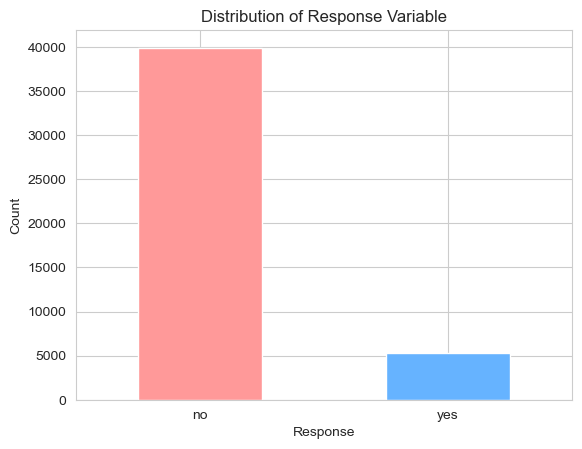

In [47]:
data['response'].value_counts().plot(kind='bar', color=['#FF9999', '#66B3FF'])
plt.title('Distribution of Response Variable')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Exploratory Data Analysis with Seaborn
Visualize the data with Seaborn to understand the distribution of features and the relationship between features
and the target variable.

<Figure size 800x1200 with 0 Axes>

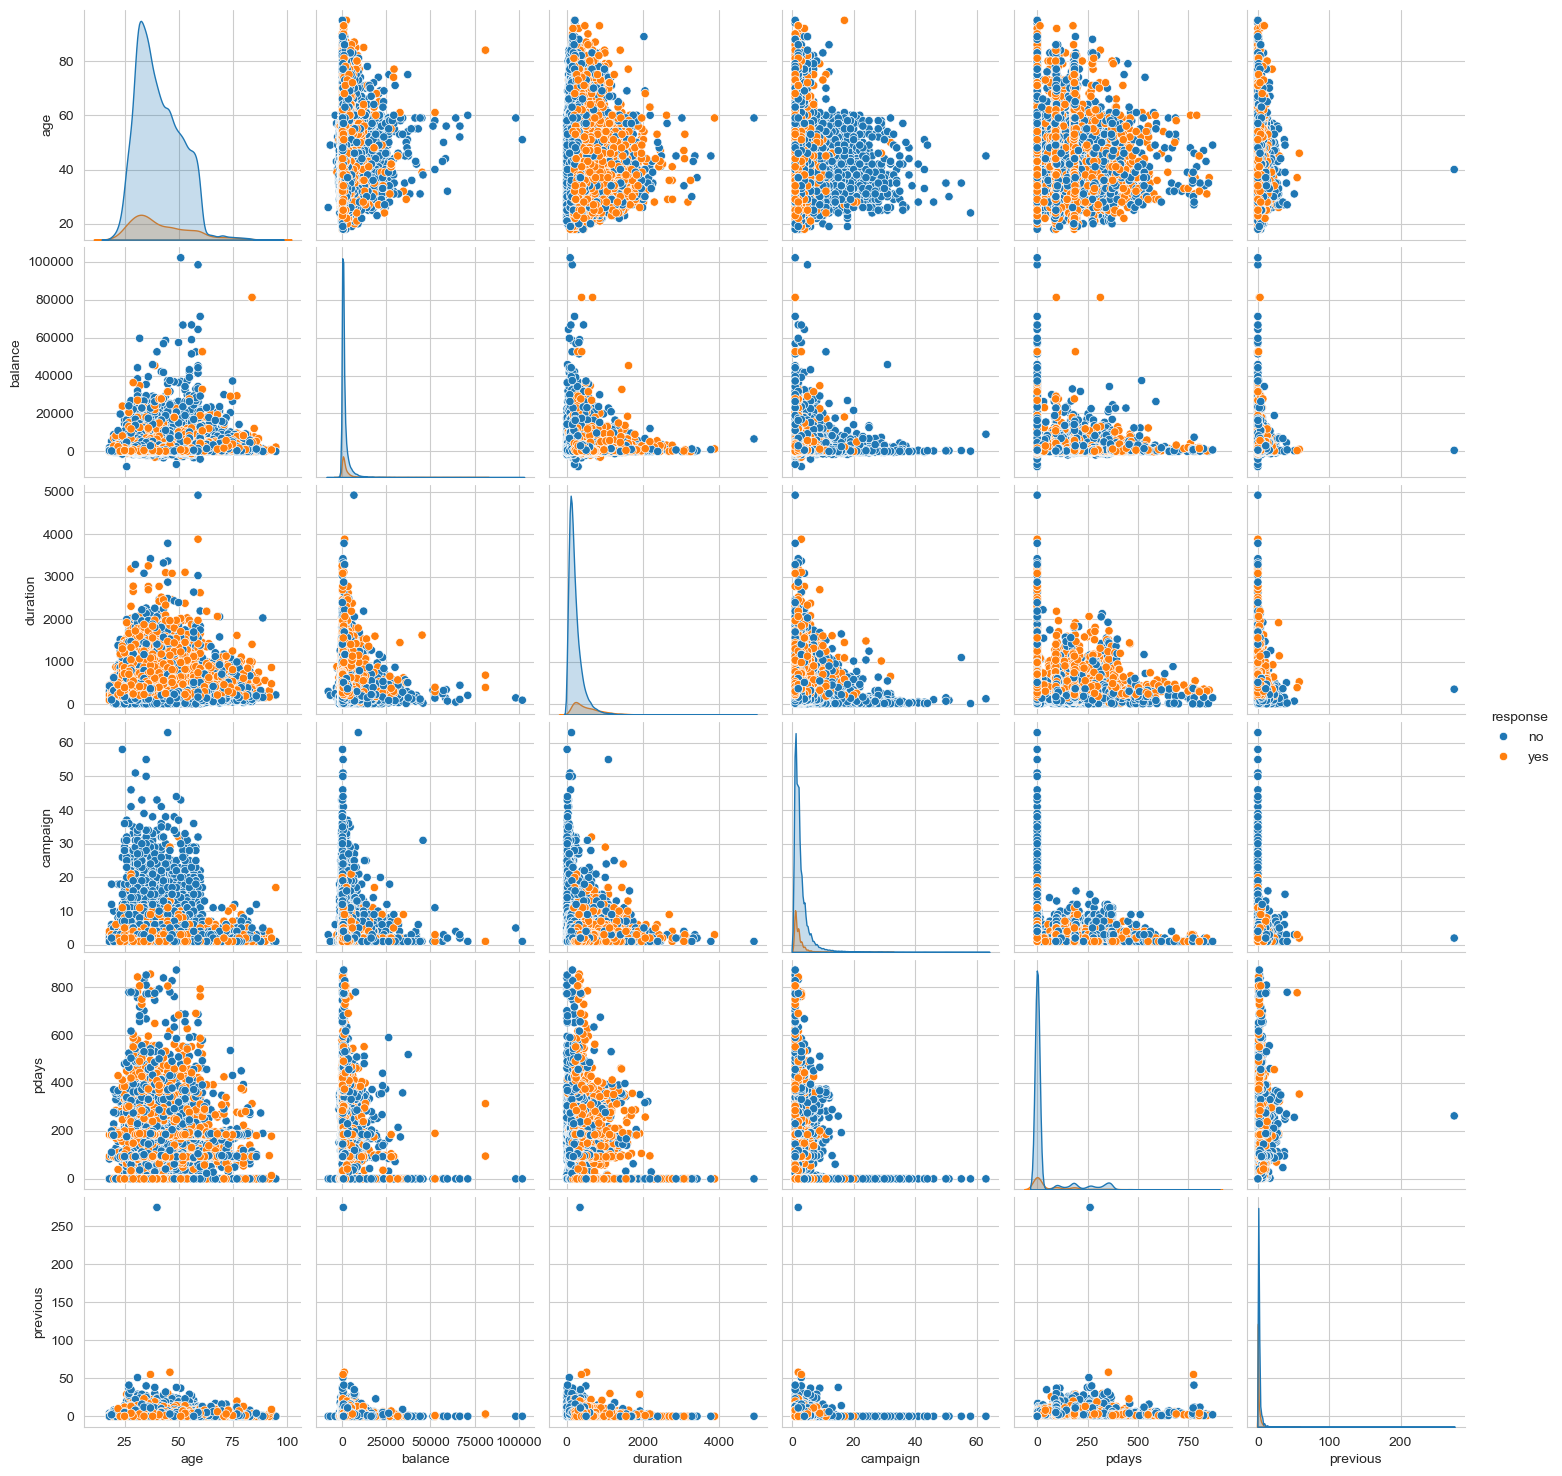

In [48]:
plt.figure(figsize=(8,12))
sns.set_style('whitegrid')
sns.pairplot(data,hue='response')
plt.show()

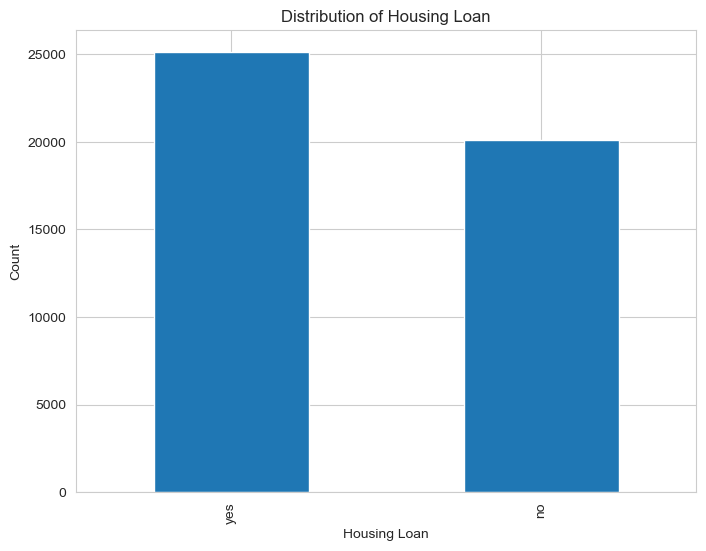

In [49]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar')
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

<Figure size 1200x800 with 0 Axes>

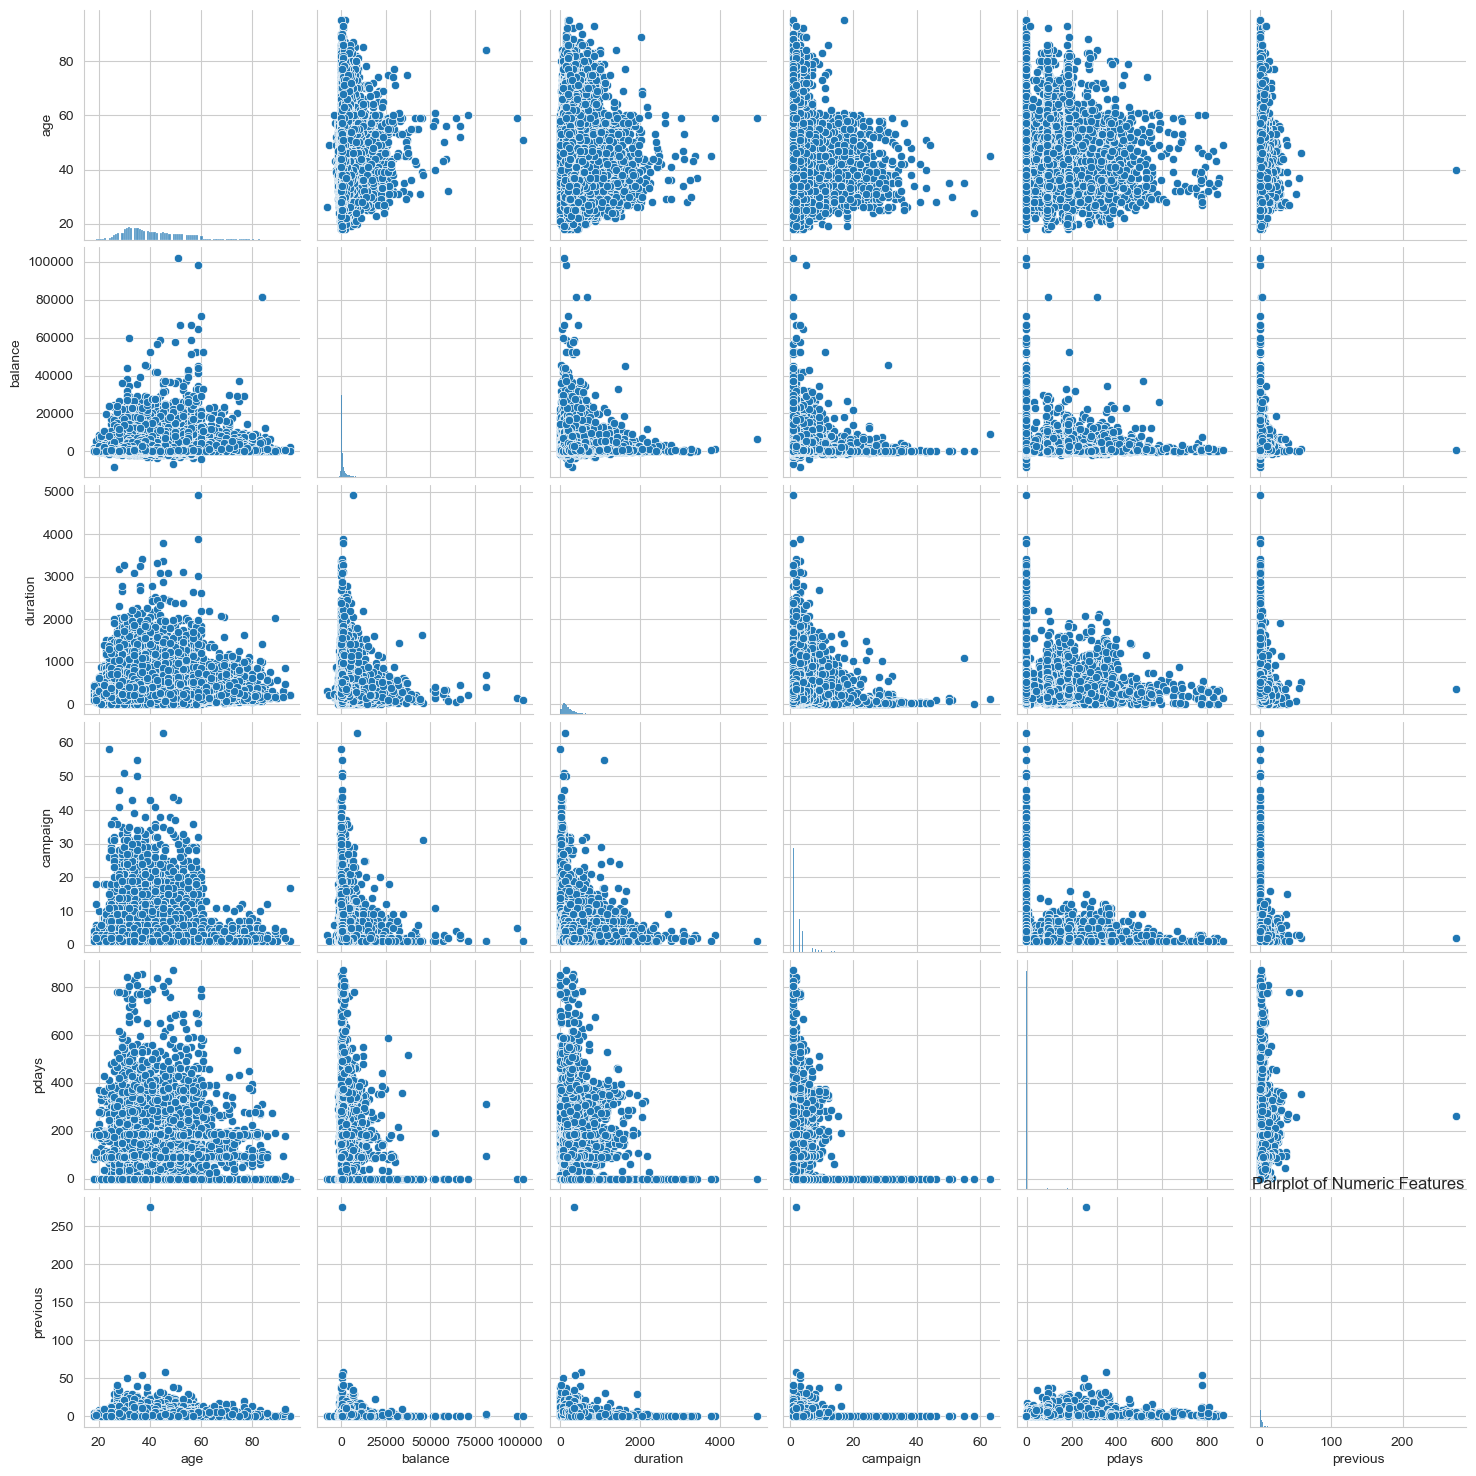

In [50]:
# Distribution plot of numeric features
plt.figure(figsize=(12, 8))
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
sns.pairplot(numeric_ft)
plt.title('Pairplot of Numeric Features')
plt.show()


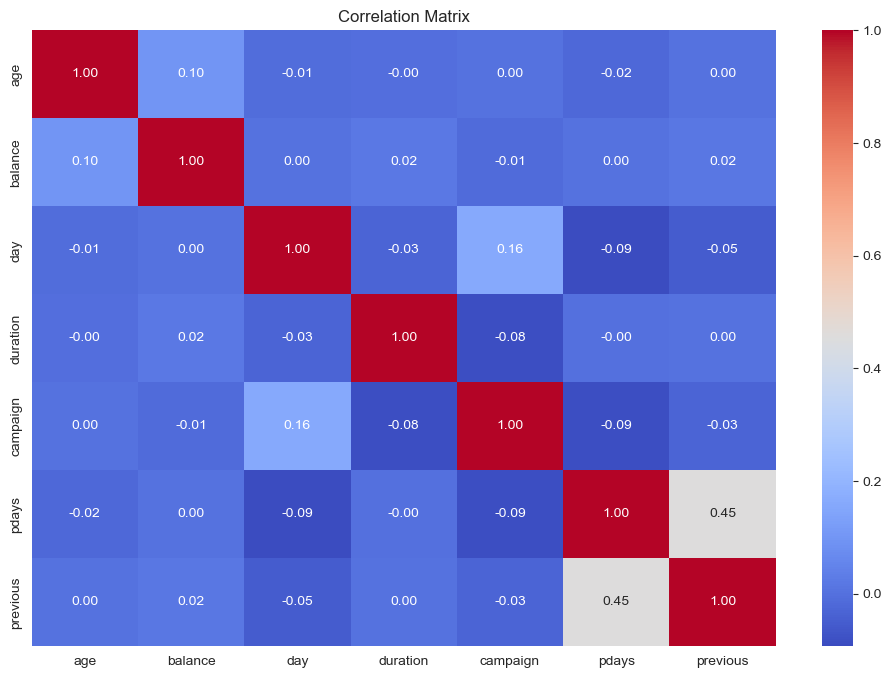

In [51]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Assign features and labels

In [52]:
X=data.drop(columns=['response'])
y=data['response']
print(X.shape)
print(y.shape)

(45211, 15)
(45211,)


In [54]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

Apply Preprocessing to Data

In [55]:
# Separate numeric and categorical features
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'contact', 'credit_default']

In [56]:
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

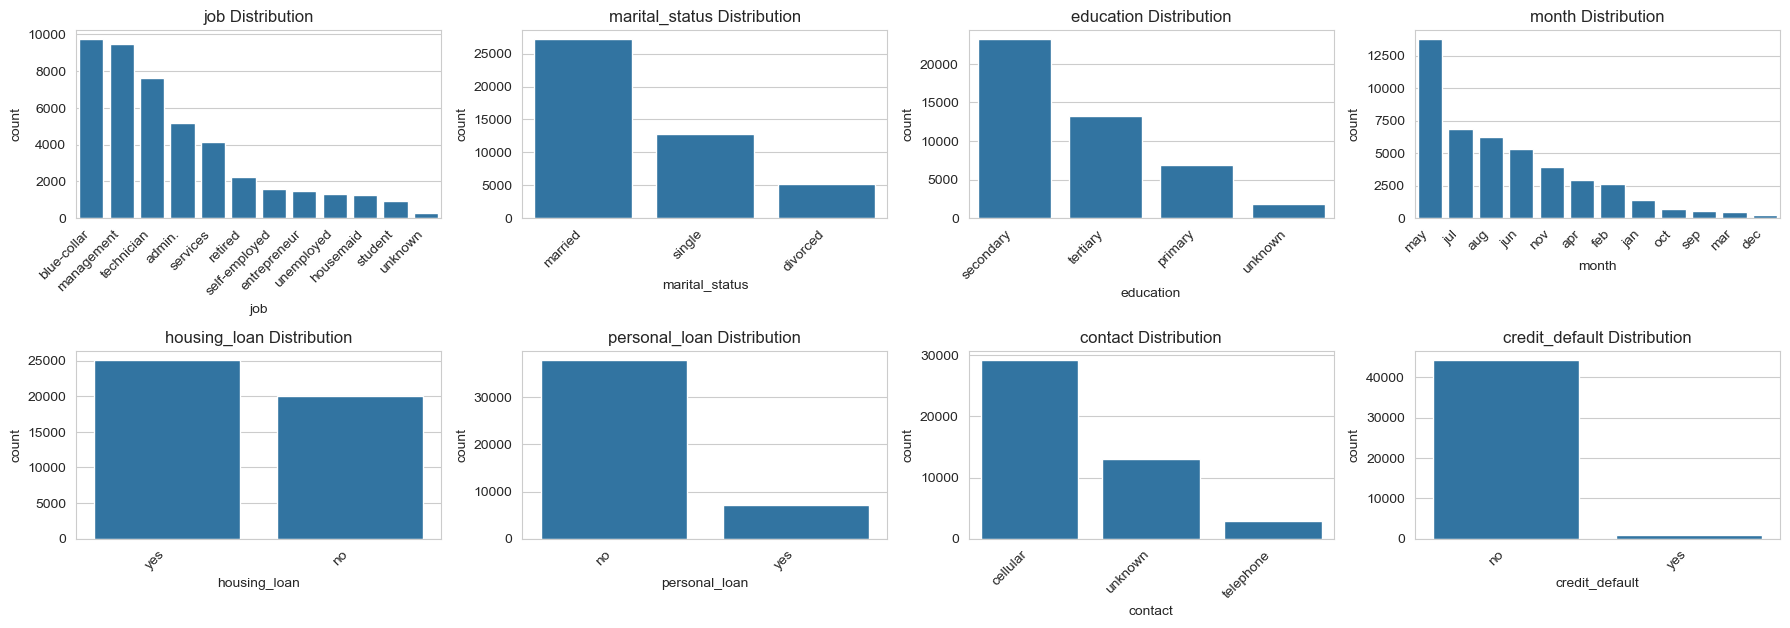

In [58]:
# Create subplots for the categorical variables
plt.figure(figsize=(18, 12))  
for i, variable in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i) 
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show() 

In [59]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [60]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [61]:
print(X_train.shape)
print(X_test.shape)


(36168, 47)
(9043, 47)


In [62]:
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train, y_train) # type: ignore

Logistic Regression with Scikit-learn training steps

In [63]:
#Instantiate and train
logreg=LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

Logistic Regression
Accuracy:  0.8256109698109034
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.80      0.52      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.82      0.71      9043
weighted avg       0.90      0.83      0.85      9043

Confusion Matrix: 
 [[6616 1369]
 [ 208  850]]
ROC_AUC_Score:  0.8899573041608024


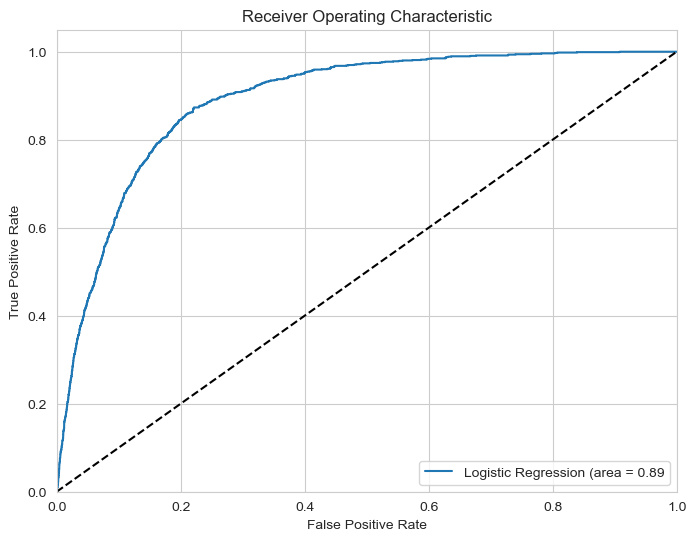

In [64]:
# Predict, Evaluate and plot
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print("Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC_AUC_Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Logistic Regression (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()     

Decision Tree with Scikit-learn training steps

Decision Tree Classifier
Accuracy:  0.8645361052747982
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      7985
           1       0.43      0.52      0.47      1058

    accuracy                           0.86      9043
   macro avg       0.68      0.72      0.70      9043
weighted avg       0.88      0.86      0.87      9043

Confusion Matrix: 
 [[7265  720]
 [ 505  553]]
ROC AUC Score:  0.7162576215091386


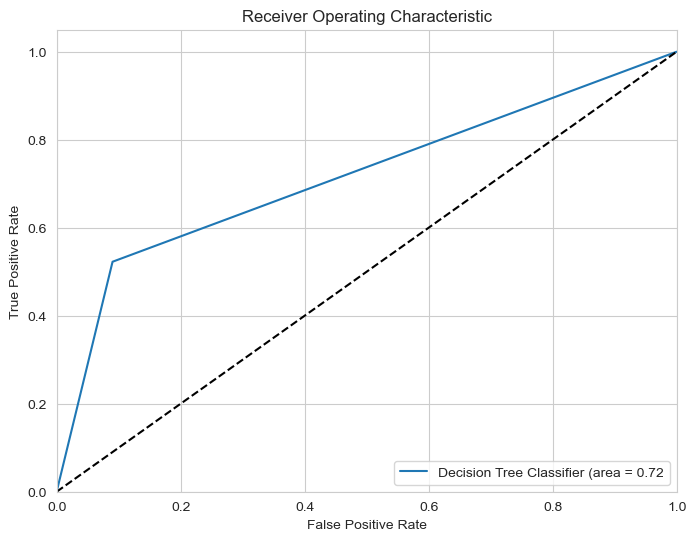

In [65]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
y_pred_proba=dtree.predict_proba(X_test)[:,1]
print("Decision Tree Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Decision Tree Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Random Forest with Scikit-learn training steps

Random Forest Classifier
Accuracy:  0.8920712153046555
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.54      0.53      0.53      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.73      0.74      9043
weighted avg       0.89      0.89      0.89      9043

Confusion Matrix: 
 [[7511  474]
 [ 502  556]]
ROC AUC Score:  0.9200333683312165


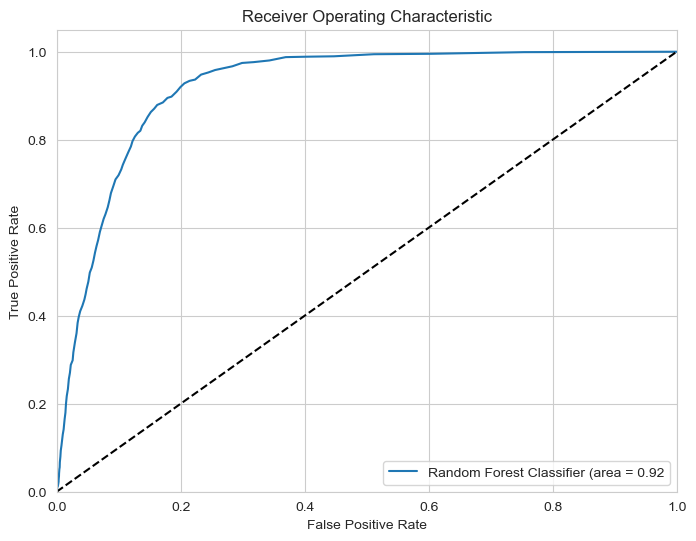

In [66]:
#Random Forest Classifier
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
rforest.fit(X_train,y_train)
y_pred=rforest.predict(X_test)
y_pred_proba=rforest.predict_proba(X_test)[:,1]
print("Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Random Forest Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Gradient Boosting with Scikit-learn training steps

Gradient Boosting Classifier
Accuracy:  0.8731615614287294
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      7985
           1       0.47      0.74      0.58      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.82      0.75      9043
weighted avg       0.91      0.87      0.88      9043

Confusion Matrix: 
 [[7113  872]
 [ 275  783]]
ROC AUC Score:  0.9099446859837622


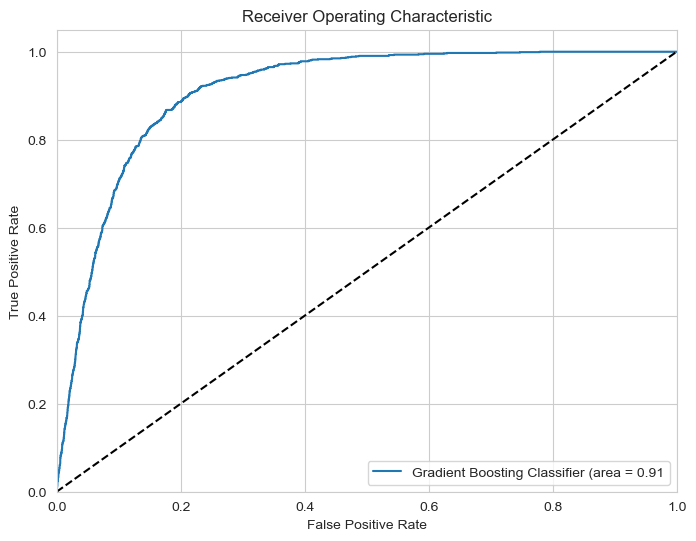

In [67]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train,y_train)
y_pred=gbm.predict(X_test)
y_pred_proba=gbm.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

GaussianNB with Scikit-learn training steps

Gaussian Naive Bayes
Accuracy:  0.733384938626562
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.74      0.83      7985
           1       0.25      0.66      0.37      1058

    accuracy                           0.73      9043
   macro avg       0.60      0.70      0.60      9043
weighted avg       0.86      0.73      0.78      9043

Confusion Matrix: 
 [[5938 2047]
 [ 364  694]]
ROC AUC Score:  0.7535944641003394


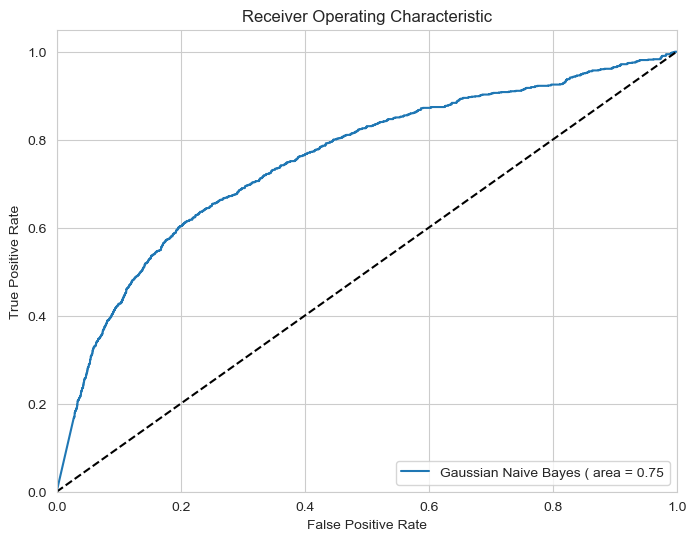

In [68]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
y_pred_proba=gnb.predict_proba(X_test)[:,1]
print("Gaussian Naive Bayes")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gaussian Naive Bayes ( area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNeighbors with Scikit-learn training steps

K Neighbors Classifier
Accuracy:  0.8374433263297578
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.71      0.51      1058

    accuracy                           0.84      9043
   macro avg       0.67      0.78      0.70      9043
weighted avg       0.89      0.84      0.86      9043

Confusion Matrix: 
 [[6821 1164]
 [ 306  752]]
ROC AUC Score:  0.8431400795205566


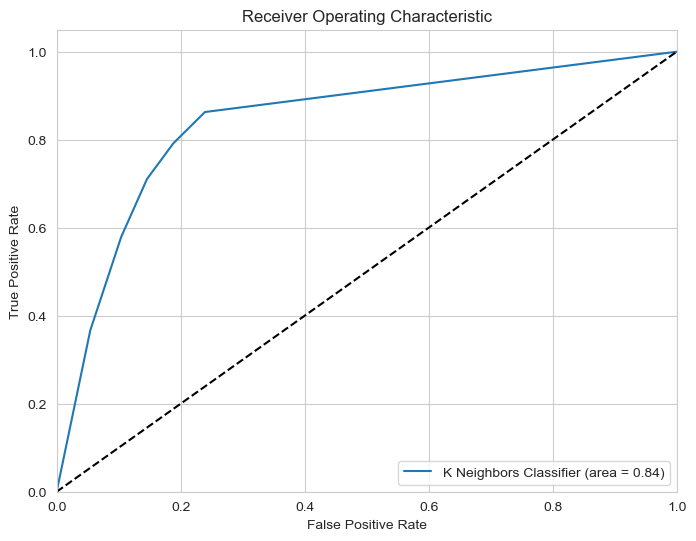

In [69]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
y_pred_proba=knn.predict_proba(X_test)[:,1]
print("K Neighbors Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='K Neighbors Classifier (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [70]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)),  
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]),  # type: ignore
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])] # type: ignore
})

In [72]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

                  Model  Accuracy  ROC_AUC_Score
0         Random Forest  0.892071       0.920033
1     Gradient Boosting  0.873162       0.909945
2   Logistic Regression  0.825611       0.889957
3           K Neighbors  0.837443       0.843140
4  Gaussian Naive Bayes  0.733385       0.753594
5         Decision Tree  0.864536       0.716258


In [73]:
# Save the model
joblib.dump(logreg, '../saved_models/logreg_model.pkl')
joblib.dump(dtree, '../saved_models/dtree_model.pkl')
joblib.dump(rforest, '../saved_models/rforest_model.pkl')
joblib.dump(gbm, '../saved_models/gbm_model.pkl')
joblib.dump(gnb, '../saved_models/gnb_model.pkl')
joblib.dump(knn, '../saved_models/knn_model.pkl')
joblib.dump(pre_pipeline, '../saved_models/pre_pipeline.pkl')
joblib.dump(label_encoder, '../saved_models/label_encoder.pkl')

['../saved_models/label_encoder.pkl']

In [74]:
# Load the model
logreg_ = joblib.load('../saved_models/logreg_model.pkl')
dtree_ = joblib.load('../saved_models/dtree_model.pkl')
rforest_ = joblib.load('../saved_models/rforest_model.pkl')
gbm_ = joblib.load('../saved_models/gbm_model.pkl')
gnb_ = joblib.load('../saved_models/gnb_model.pkl')
knn_ = joblib.load('../saved_models/knn_model.pkl')
pre_pipeline_ = joblib.load('../saved_models/pre_pipeline.pkl')
label_encoder_ = joblib.load('../saved_models/label_encoder.pkl')

In [75]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'contact': ['cellular'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [76]:
# Preprocess the new data
new_d = pd.DataFrame(pre_pipeline_.transform(new_data), columns=pre_pipeline_.get_feature_names_out()) # type: ignore

In [77]:

# Make predictions
logreg_pred = logreg_.predict(new_d)
dtree_pred = dtree_.predict(new_d)
rforest_pred = rforest_.predict(new_d)
gbm_pred = gbm_.predict(new_d)
gnb_pred = gnb_.predict(new_d)
knn_pred = knn_.predict(new_d)
# Print the predictions
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("K Neighbors Prediction: ", knn_pred)

Logistic Regression Prediction:  [1]
Decision Tree Prediction:  [0]
Random Forest Prediction:  [0]
Gradient Boosting Prediction:  [0]
Gaussian Naive Bayes Prediction:  [1]
K Neighbors Prediction:  [1]
